<a href="https://colab.research.google.com/github/gunighose/Ac225-MDev/blob/main/notebooks/MDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run alls

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import scipy.optimize as optim
from scipy.interpolate import interp1d

In [ ]:
path = 'data/Ac225.csv'
df = pd.read_csv(path)
df.columns = ["ADC_channels","counts"]

In [ ]:
# binning and errors manually
binned_counts, bin_edges = np.histogram(df["ADC_channels"], bins=250, weights=df["counts"], range=(0,2000))
bin_edges = bin_edges[:-1]
df_bin = pd.DataFrame()
df_bin.index = bin_edges
df_bin["counts"] = binned_counts

## Logistic function (experimental)

<>:61: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1418184882.py:61: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(x_fit, y_fit, color="mediumseagreen", linewidth=1, label=f"$\chi^2/ndf$ = {chisqd:.1f} / {ndfs:.0f}")
/tmp/ipython-input-1418184882.py:62: SyntaxWarning: invalid escape sequence '\s'
  ax.fill_between(x_fit, y_lower, y_upper, color="mediumseagreen", alpha=0.3, label="1$\sigma$ error band")


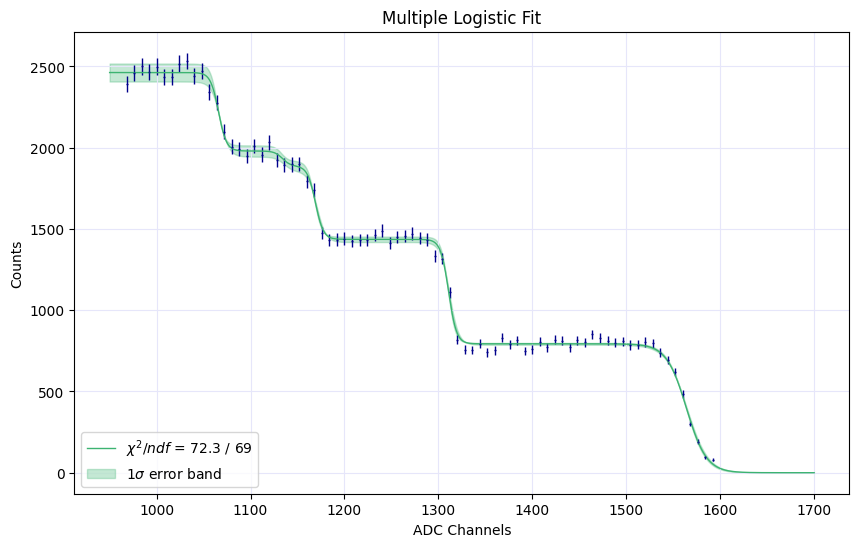

In [ ]:
def logistic_b(x, x0, a, b):
    return a / (1 + np.exp(-(x - x0) / b))

# Define the multi-step sigmoid with a shared b
def multi_logistic_b(x,
                                x0_1, a1,
                                x0_2, a2,  # a2 now split
                                x0_3, a3,
                                x0_4, a4,
                                b, b4):  # shared steepness
    # Compute sub-step amplitudes and centers
    a2a = 0.17 * a2
    a2b = 0.83 * a2
    x0_2a = 0.97 * x0_2

    # Return sum of sigmoids minus total amplitude
    return (
        logistic_b(x, x0_1, a1, b) +
        logistic_b(x, x0_2a, a2a, b) +
        logistic_b(x, x0_2, a2b, b) +
        logistic_b(x, x0_3, a3, b) +
        logistic_b(x, x0_4, a4, b4) - (a1 + a2a + a2b + a3 + a4)
    )

# Chi squared
def chi_sqrd(params, x, y, yerr):
  X_sqrd = []
  f_x = np.array(multi_logistic_b(x, *params))
  X_sqrd = np.sum((y - f_x)**2 / yerr**2)
  ndf = len(x) - len(params)
  return X_sqrd, ndf

# Load data
bin_edges = df_bin.index[(df_bin.index > 960) & (df_bin.index < 1600)]
binned_counts = df_bin["counts"][(df_bin.index > 960) & (df_bin.index < 1600)]
bin_errors = np.sqrt(binned_counts)

# Initial guesses: x0_i, a_i, for each step, plus one shared b and c
p_b = [1050, -500,
      1150, -500,
      1300, -600,
      1550, -700,
      10, 15]

# Fit the curve
params, cov = curve_fit(multi_logistic_b, bin_edges, binned_counts, p0=p_b, sigma=bin_errors, absolute_sigma=True)
chisqd, ndfs = chi_sqrd(params, bin_edges, binned_counts, bin_errors)

# Generate x values for smooth fit
x_fit = np.linspace(950, 1700, 10000)
y_fit = multi_logistic_b(x_fit, *params)

# Compute covariance error
errors_b = np.sqrt(np.diag(cov))
y_lower = multi_logistic_b(x_fit, *(params-errors_b))
y_upper = multi_logistic_b(x_fit, *(params+errors_b))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(bin_edges, binned_counts, yerr=bin_errors, color="darkblue", fmt=".", markersize=1, elinewidth=1)
ax.plot(x_fit, y_fit, color="mediumseagreen", linewidth=1, label=f"$\chi^2/ndf$ = {chisqd:.1f} / {ndfs:.0f}")
ax.fill_between(x_fit, y_lower, y_upper, color="mediumseagreen", alpha=0.3, label="1$\sigma$ error band")
ax.grid(visible=True, color="lavender")
ax.legend(loc="lower left")
ax.set_xlabel('ADC Channels')
ax.set_ylabel('Counts')
ax.set_title('Multiple Logistic Fit')
plt.show()

# Modelling using the multiple S-curve function

<>:61: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3894187986.py:61: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(x_fit, y_fit, color="mediumpurple", linewidth=1, label=f"$\chi^2/ndf$ = {chisqd:.1f} / {ndfs:.0f}")
/tmp/ipython-input-3894187986.py:62: SyntaxWarning: invalid escape sequence '\s'
  ax.fill_between(x_fit, y_lower, y_upper, color="mediumpurple", alpha=0.3, label="1$\sigma$ error band")


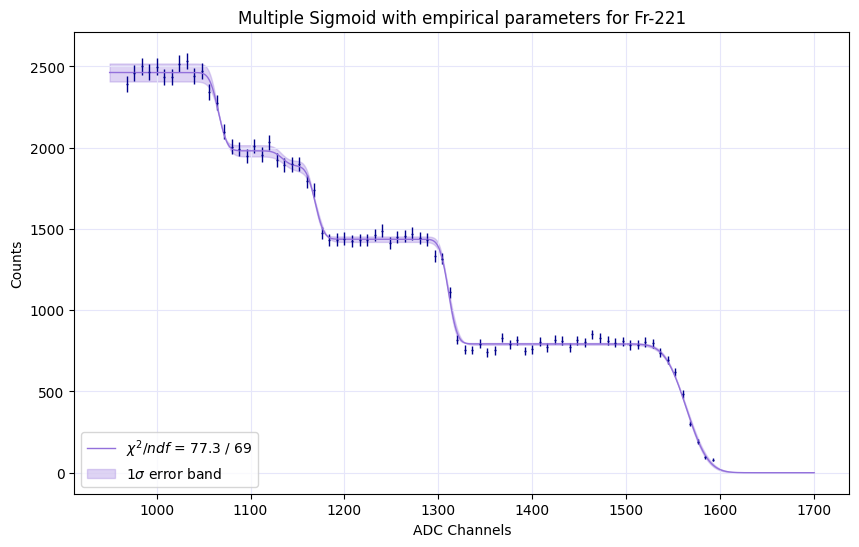

In [ ]:
def sigmoid_b(x, x0, a, b):
    return a * 0.5 * (1 + scipy.special.erf((x - x0) / (b * np.sqrt(2))))

# Define the multi-step sigmoid with a shared b
def multi_sigmoid_shared_b(x,
                                x0_1, a1,
                                x0_2, a2,  # a2 now split
                                x0_3, a3,
                                x0_4, a4,
                                b, b4):  # shared steepness
    # Compute sub-step amplitudes and centers
    a2a = 0.17 * a2
    a2b = 0.83 * a2
    x0_2a = 0.97 * x0_2

    # Return sum of sigmoids minus total amplitude
    return (
        sigmoid_b(x, x0_1, a1, b) +
        sigmoid_b(x, x0_2a, a2a, b) +
        sigmoid_b(x, x0_2, a2b, b) +
        sigmoid_b(x, x0_3, a3, b) +
        sigmoid_b(x, x0_4, a4, b4) - (a1 + a2a + a2b + a3 + a4)
    )

# Chi squared
def chi_sqrd(params, x, y, yerr):
  X_sqrd = []
  f_x = np.array(multi_sigmoid_shared_b(x, *params))
  X_sqrd = np.sum((y - f_x)**2 / yerr**2)
  ndf = len(x) - len(params)
  return X_sqrd, ndf

# Load data
bin_edges = df_bin.index[(df_bin.index > 960) & (df_bin.index < 1600)]
binned_counts = df_bin["counts"][(df_bin.index > 960) & (df_bin.index < 1600)]
bin_errors = np.sqrt(binned_counts)

# Initial guesses: x0_i, a_i, for each step, plus one shared b and c
p_b = [1050, -500,
      1150, -500,
      1300, -600,
      1550, -700,
      10, 15]

# Fit the curve
params, cov = curve_fit(multi_sigmoid_shared_b, bin_edges, binned_counts, p0=p_b, sigma=bin_errors, absolute_sigma=True)
chisqd, ndfs = chi_sqrd(params, bin_edges, binned_counts, bin_errors)

# Generate x values for smooth fit
x_fit = np.linspace(950, 1700, 10000)
y_fit = multi_sigmoid_shared_b(x_fit, *params)

# Compute covariance error
errors_b = np.sqrt(np.diag(cov))
y_lower = multi_sigmoid_shared_b(x_fit, *(params-errors_b))
y_upper = multi_sigmoid_shared_b(x_fit, *(params+errors_b))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(bin_edges, binned_counts, yerr=bin_errors, color="darkblue", fmt=".", markersize=1, elinewidth=1)
ax.plot(x_fit, y_fit, color="mediumpurple", linewidth=1, label=f"$\chi^2/ndf$ = {chisqd:.1f} / {ndfs:.0f}")
ax.fill_between(x_fit, y_lower, y_upper, color="mediumpurple", alpha=0.3, label="1$\sigma$ error band")
ax.grid(visible=True, color="lavender")
ax.legend(loc="lower left")
ax.set_xlabel('ADC Channels')
ax.set_ylabel('Counts')
ax.set_title('Multiple Sigmoid with empirical parameters for Fr-221')
plt.show()